In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u, constants as cst
import sys, os

sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = True

TIM = p.TIM
FYST = p.FYST
LADUMA = p.LADUMA

In [12]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zmax),
]
bands = ['SW', 'LW']

LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

In [13]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]

C:\Users\shubh\AppData\Local\Temp\ipykernel_150292\2700390269.py:8: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


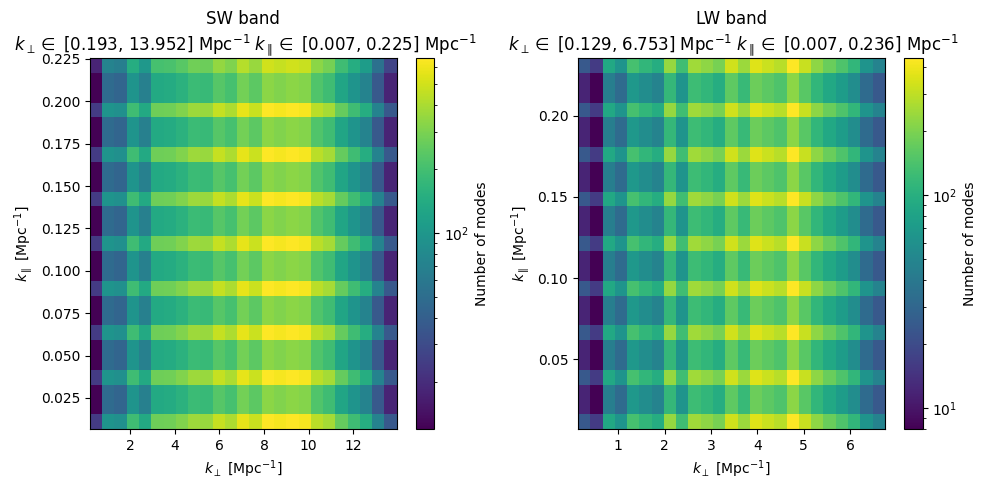

In [14]:
# plot 2d histograms of k_para vs k_perp
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    # sanitize inf and nan values
    mask = np.logical_and(k_para[i] != 0, k_perp[i] != 0)
    # mask = True
    minperp = np.nanmin(k_perp[i][mask])
    minpara = np.nanmin(k_para[i][mask])
    maxperp = np.nanmax(k_perp[i][mask])
    maxpara = np.nanmax(k_para[i][mask])
    # k_perp[i][~np.isfinite(k_perp[i])] = 0
    # k_para[i][~np.isfinite(k_para[i])] = 0

    # minperp, maxperp = .999, 1
    # minpara, maxpara = 0, .1

    h = ax[i].hist2d(k_perp[i].flatten(), k_para[i].flatten(), bins=25, norm=plt.cm.colors.LogNorm(),
                    range=[[minperp, maxperp], [minpara, maxpara]], cmap='viridis')
    ax[i].set_title(f'{bands[i]} band\n' r"$\; k_{\perp} \in$" f' [{minperp:.3f}, {maxperp:.3f}] Mpc$^{{-1}}$' +
                    r"$\; k_{\parallel} \in$" f' [{minpara:.3f}, {maxpara:.3f}] Mpc$^{{-1}}$')
    ax[i].set_xlabel(r'$k_{\perp}$ [Mpc$^{-1}$]')
    ax[i].set_ylabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
    # ax[i].set_xscale('log')
    # ax[i].set_yscale('log')
    ax[i].set_xlim(minperp, maxperp)
    ax[i].set_ylim(minpara, maxpara)
    fig.colorbar(h[3], ax=ax[i], label='Number of modes')
plt.tight_layout()
plt.savefig('temp.png', dpi=300)

In [15]:
0.52, 1.00, 1.66

(0.52, 1.0, 1.66)

In [16]:
# Meerkat and 21 cm
# https://skaafrica.atlassian.net/servicedesk/customer/portal/1/article/277315585
nu21 = 1420 * u.MHz
zedges = [0.5, 1.0, 1.66]
zcens = [(zedges[i] + zedges[i+1]) / 2 for i in range(len(zedges) - 1)]
print(zcens)
print([nu21 / (1 + z) for z in zedges])
print([nu21 / (1 + z) for z in zcens])
# UHF band of MeerKAT is 580-1015 MHz

maxbaseline = 7700 * u.m
minbaseline = 29 * u.m
ndish = 64
uhfbandres = 132 * u.kHz # 4k mode, there is a 32k mode too 
uhfbandwidths = np.diff([(nu21 / (1 + z)).to(u.MHz).value for z in zedges[::-1]])[::-1] * u.MHz
print(uhfbandwidths)

[0.75, 1.33]
[<Quantity 946.66666667 MHz>, <Quantity 710. MHz>, <Quantity 533.83458647 MHz>]
[<Quantity 811.42857143 MHz>, <Quantity 609.44206009 MHz>]
[236.66666667 176.16541353] MHz


In [17]:
# comoving radial distance per unit frequency
def dchi_dnu(z):
    return (cst.c * (1 + z) ** 2 / cosmo.H(z) / nu21).to(u.Mpc / u.MHz)

print([dchi_dnu(z) for z in zcens])

kparamins = [2 * np.pi / (dchi_dnu(z) * bw).to(u.Mpc) for z, bw in zip(zcens, uhfbandwidths)]
kparamaxs = [2 * np.pi / (dchi_dnu(z) * uhfbandres).to(u.Mpc) for z in zcens]
print(kparamins)
print(kparamaxs)

[<Quantity 6.2247128 Mpc / MHz>, <Quantity 7.87600856 Mpc / MHz>]
[<Quantity 0.00426504 1 / Mpc>, <Quantity 0.00452849 1 / Mpc>]
[<Quantity 7.64692127 1 / Mpc>, <Quantity 6.04365629 1 / Mpc>]


In [18]:
# transverse comoving distance
def D_M(z):
    return cosmo.comoving_transverse_distance(z).to(u.Mpc)

# u from baseline and redshift
def u_f(b, z):
    lam_obs = (cst.c / (nu21 / (1 + z))).to(u.m)
    return (b / lam_obs).to("")

kperpmins = [2 * np.pi / D_M(z) * u_f(minbaseline, z) for z in zcens]
kperpmaxs = [2 * np.pi / D_M(z) * u_f(maxbaseline, z) for z in zcens]
print(kperpmins)
print(kperpmaxs)

[<Quantity 0.18093636 1 / Mpc>, <Quantity 0.08941632 1 / Mpc>]
[<Quantity 48.04172298 1 / Mpc>, <Quantity 23.74157557 1 / Mpc>]


In [19]:
HIks = [((kperpmin, kperpmax), (kparamin, kparamax)) for kperpmin, kperpmax, kparamin, kparamax in zip(kperpmins, kperpmaxs, kparamins, kparamaxs)]
print(HIks[0])
print(HIks[1])

((<Quantity 0.18093636 1 / Mpc>, <Quantity 48.04172298 1 / Mpc>), (<Quantity 0.00426504 1 / Mpc>, <Quantity 7.64692127 1 / Mpc>))
((<Quantity 0.08941632 1 / Mpc>, <Quantity 23.74157557 1 / Mpc>), (<Quantity 0.00452849 1 / Mpc>, <Quantity 6.04365629 1 / Mpc>))


In [20]:
print((cst.c / 420 / u.micron).to(u.THz),
    (cst.c / 315 / u.micron).to(u.THz), 
    (cst.c / 240 / u.micron).to(u.THz))

0.7137915666666667 THz 0.9517220888888889 THz 1.2491352416666666 THz


In [21]:
# TIM and CII
nuCII = 1900.54 * u.GHz
zedges = [0.5, 1.0, 1.66]
zcens = [(zedges[i] + zedges[i+1]) / 2 for i in range(len(zedges) - 1)]
print(zcens)
print([nuCII / (1 + z) for z in zedges])
print([nuCII / (1 + z) for z in zcens])
# TIM band is .7-1.25 THz

aperture = 2 * u.m
fieldsize = 1 * u.deg
R = 250
dnus = [4.4 * u.GHz, 3.3 * u.GHz]
Dnus = np.diff([(nuCII / (1 + z)).to(u.GHz).value for z in zedges[::-1]])[::-1] * u.GHz
print(Dnus)

[0.75, 1.33]
[<Quantity 1267.02666667 GHz>, <Quantity 950.27 GHz>, <Quantity 714.4887218 GHz>]
[<Quantity 1086.02285714 GHz>, <Quantity 815.68240343 GHz>]
[316.75666667 235.7812782 ] GHz


In [22]:
# comoving radial distance per unit frequency, for CII
# This is the same as for HI, but with nu21 replaced by nuCII
def dchi_dnu(z):
    return (cst.c * (1 + z) ** 2 / cosmo.H(z) / nuCII).to(u.Mpc / u.MHz)

print([dchi_dnu(z) for z in zcens])

kparamaxs = [2 * np.pi / (dchi_dnu(z) * dnu).to(u.Mpc) for z, dnu in zip(zcens, dnus)]
kparamins = [2 * np.pi / (dchi_dnu(z) * Dnu).to(u.Mpc) for z, Dnu in zip(zcens, Dnus)]
print(kparamins)
print(kparamaxs)

[<Quantity 0.00465083 Mpc / MHz>, <Quantity 0.00588461 Mpc / MHz>]
[<Quantity 0.00426504 1 / Mpc>, <Quantity 0.00452849 1 / Mpc>]
[<Quantity 0.30704112 1 / Mpc>, <Quantity 0.32355523 1 / Mpc>]


In [23]:
# transverse comoving distance
def D_M(z):
    return cosmo.comoving_transverse_distance(z).to(u.Mpc)

beamthetas = [((1.22 * (cst.c / (nuCII / (1 + zcen))) / aperture).to("") * u.rad).to(u.arcmin) for zcen in zcens]
print(beamthetas)

kperpmaxs = [2 * np.pi / D_M(z) / beamtheta.to(u.rad).value for z, beamtheta in zip(zcens, beamthetas)]
kperpmins = [2 * np.pi / D_M(z) / fieldsize.to(u.rad).value for z in zcens]
print(kperpmins)
print(kperpmaxs)

[<Quantity 0.57887588 arcmin>, <Quantity 0.77073189 arcmin>]
[<Quantity 0.13207508 1 / Mpc>, <Quantity 0.08690199 1 / Mpc>]
[<Quantity 13.68947158 1 / Mpc>, <Quantity 6.76515337 1 / Mpc>]


In [24]:
CIIks = [((kperpmin, kperpmax), (kparamin, kparamax)) for kperpmin, kperpmax, kparamin, kparamax in zip(kperpmins, kperpmaxs, kparamins, kparamaxs)]
print(CIIks[0])
print(CIIks[1])

((<Quantity 0.13207508 1 / Mpc>, <Quantity 13.68947158 1 / Mpc>), (<Quantity 0.00426504 1 / Mpc>, <Quantity 0.30704112 1 / Mpc>))
((<Quantity 0.08690199 1 / Mpc>, <Quantity 6.76515337 1 / Mpc>), (<Quantity 0.00452849 1 / Mpc>, <Quantity 0.32355523 1 / Mpc>))


In [25]:
# FYST and CO
nuCO = lambda J: (115.271202 * J) * u.GHz  # CO J+1 to J
zedges = [0.5, 1.0, 1.66]
zcens = [(zedges[i] + zedges[i+1]) / 2 for i in range(len(zedges) - 1)]
print(zcens)

nuCOs = [nuCO(4), nuCO(5)]

print([nuCOs[0] / (1 + z) for z in zedges[:-1]])
print([nuCOs[1] / (1 + z) for z in zedges[1:]])
print([nuCO / (1 + zcen) for zcen, nuCO in zip(zcens, nuCOs)])
# FYST band is 210 - 420 GHz
# http://ui.adsabs.harvard.edu/abs/2023pcsf.conf..352N/abstract
aperture = 6 * u.m
fieldsize = 1.3 * u.deg
R = 100
dnu = 2.8 * u.GHz
Dnus = [nuCOs[0] / (1 + zedges[0]) - nuCOs[0] / (1 + zedges[1]),
        nuCOs[1] / (1 + zedges[1]) - nuCOs[1] / (1 + zedges[2])]

print(Dnus)

[0.75, 1.33]
[<Quantity 307.389872 GHz>, <Quantity 230.542404 GHz>]
[<Quantity 288.178005 GHz>, <Quantity 216.67519173 GHz>]
[<Quantity 263.47703314 GHz>, <Quantity 247.36309442 GHz>]
[<Quantity 76.847468 GHz>, <Quantity 71.50281327 GHz>]


In [26]:
# comoving radial distance per unit frequency, for CO
def dchi_dnu(z, nuCO):
    return (cst.c * (1 + z) ** 2 / cosmo.H(z) / nuCO).to(u.Mpc / u.MHz)

print([dchi_dnu(z, nuCO) for z, nuCO in zip(zcens, nuCOs)])

kparamaxs = [2 * np.pi / (dchi_dnu(z, nuCO) * dnu).to(u.Mpc) for z, nuCO in zip(zcens, nuCOs)]
kparamins = [2 * np.pi / (dchi_dnu(z, nuCO) * Dnu).to(u.Mpc) for z, Dnu, nuCO in zip(zcens, Dnus, nuCOs)]
print(kparamins)
print(kparamaxs)

[<Quantity 0.01917021 Mpc / MHz>, <Quantity 0.01940456 Mpc / MHz>]
[<Quantity 0.00426504 1 / Mpc>, <Quantity 0.00452849 1 / Mpc>]
[<Quantity 0.11705635 1 / Mpc>, <Quantity 0.11564268 1 / Mpc>]


In [27]:
# transverse comoving distance
def D_M(z):
    return cosmo.comoving_transverse_distance(z).to(u.Mpc)

beamthetas = [((1.22 * (cst.c / (nuCO / (1 + zcen))) / aperture).to("") * u.rad).to(u.arcsec) for zcen, nuCO in zip(zcens, nuCOs)]
print(beamthetas)

kperpmaxs = [2 * np.pi / D_M(z) / beamtheta.to(u.rad).value for z, beamtheta in zip(zcens, beamthetas)]
kperpmins = [2 * np.pi / D_M(z) / fieldsize.to(u.rad).value for z in zcens]
print(kperpmins)
print(kperpmaxs)

[<Quantity 47.72123253 arcsec>, <Quantity 50.82992996 arcsec>]
[<Quantity 0.10159622 1 / Mpc>, <Quantity 0.06684768 1 / Mpc>]
[<Quantity 9.96349571 1 / Mpc>, <Quantity 6.15478254 1 / Mpc>]


In [28]:
COks = [((kperpmin, kperpmax), (kparamin, kparamax)) for kperpmin, kperpmax, kparamin, kparamax in zip(kperpmins, kperpmaxs, kparamins, kparamaxs)]
print(COks[0])
print(COks[1])

((<Quantity 0.10159622 1 / Mpc>, <Quantity 9.96349571 1 / Mpc>), (<Quantity 0.00426504 1 / Mpc>, <Quantity 0.11705635 1 / Mpc>))
((<Quantity 0.06684768 1 / Mpc>, <Quantity 6.15478254 1 / Mpc>), (<Quantity 0.00452849 1 / Mpc>, <Quantity 0.11564268 1 / Mpc>))


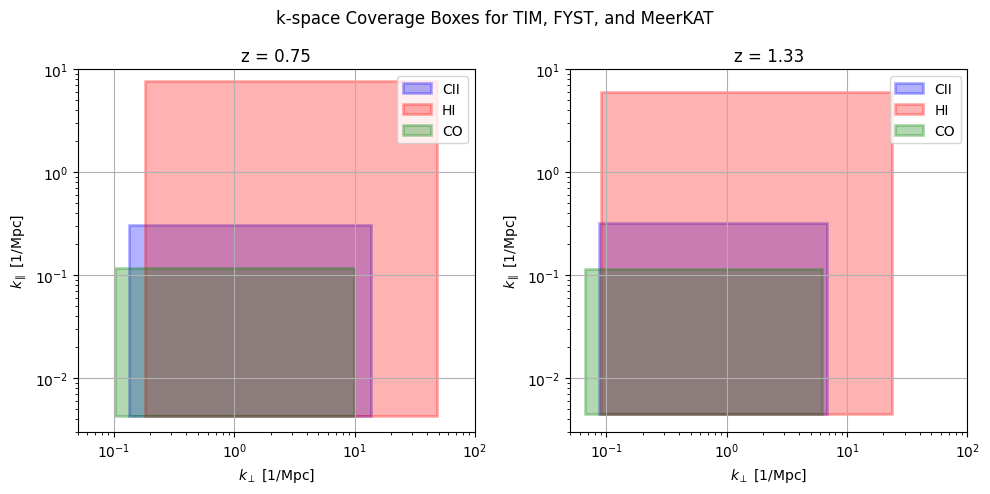

In [29]:
from matplotlib.patches import Rectangle

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for i, ax, zcen, ciik, hiks, coks in zip(range(2), [ax1, ax2], zcens, CIIks, HIks, COks):
    for j, (ks, col, label) in enumerate(zip([ciik, hiks, coks], ["blue", "red", "green"], ["CII", "HI", "CO"])):
        (kperp_min, kperp_max), (kpara_min, kpara_max) = ks[0], ks[1]
        kpara_min, kpara_max, kperp_min, kperp_max = kpara_min.value, kpara_max.value, kperp_min.value, kperp_max.value
        # Create rectangle
        width = kperp_max - kperp_min
        height = kpara_max - kpara_min
        rect = Rectangle(
            (kperp_min, kpara_min),  # bottom-left corner
            width, height,
            edgecolor=col,
            facecolor=col,
            alpha=0.3,
            label=label,
            lw=2
        )
        # Add to plot
        ax.add_patch(rect)
    ax.legend()
    ax.set_title(f'z = {zcen:.2f}')
    ax.set_xlabel(r'$k_\perp$ [1/Mpc]')
    ax.set_ylabel(r'$k_\parallel$ [1/Mpc]')
    ax.set_xlim(5e-2, 1e2)
    ax.set_ylim(3e-3, 1e1)
    ax.loglog()
    ax.grid(True)
plt.suptitle("k-space Coverage Boxes for TIM, FYST, and MeerKAT")
plt.tight_layout()